In [2]:
## reconstruction demo 
## encoder only take x as input
## spcify the trained model in the cmd_args.saved_model
from __future__ import print_function
from past.builtins import range

import os
import sys
import numpy as np
import math
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm import tqdm
from joblib import Parallel, delayed
import future
import rdkit
from rdkit import Chem
from rdkit.Chem import MolFromSmiles, MolToSmiles
from rdkit.Chem import Descriptors
from rdkit.Chem import rdmolops
from rdkit.Chem import Draw

from cmd_args import cmd_args
sys.path.append('%s/../util' % os.path.dirname(os.path.realpath('__file__')))
import cfg_parser as parser
import sascorer

from mol_tree import AnnotatedTree2MolTree, get_smiles_from_tree, Node
from attribute_tree_decoder import create_tree_decoder
from batch_make_att_masks import batch_make_att_masks
from tree_walker import OnehotBuilder, ConditionalDecoder 
from reconstruct_util import cal_accuracy
import networkx as nx

cmd_args.saved_model = './model_1/epoch-best.model'
cmd_args.training_data_dir = './../data/data_278'

grammar = parser.Grammar(cmd_args.grammar_file)
cmd_args.mode ='cpu'
label_index = 2

## load the test data
test_smiles = np.load(cmd_args.training_data_dir + '/zinc_clean_smi_test_smile.npy',allow_pickle=True)
test_unnormalized_labels = np.load(cmd_args.training_data_dir + '/zinc_clean_smi_test_y.npy', allow_pickle = True)


Sa_score_normalizer = np.load(cmd_args.training_data_dir + '/zinc_sascore_normalizer.npy', allow_pickle=True)
logP_normalizer = np.load(cmd_args.training_data_dir + '/zinc_logp_normalizer.npy', allow_pickle = True)

test_labels = np.copy(test_unnormalized_labels)
test_labels[:, 1]= test_unnormalized_labels[:,1] / Sa_score_normalizer
test_labels[:,2] = test_unnormalized_labels[:,2] / logP_normalizer

def unnormalizer(y, logP_normalizer):
    return y* np.array([logP_normalizer]).astype(np.float32)
    


In [4]:
test_unnormalized_labels = np.load(cmd_args.training_data_dir + '/zinc_clean_smi_test_y.npy', allow_pickle = True)


In [9]:
test_unnormalized_labels.max()0

6.575912763033814

In [7]:
logP_normalizer

array(8.2521)

In [ ]:
## load the model
#sys.path.append('%s/../' % os.path.dirname(os.path.realpath('__file__')))
from model import CNNEncoder, MolVAE
vae = MolVAE()
if cmd_args.mode == 'gpu':
    vae = vae.cuda()

device = torch.device('cpu')
assert cmd_args.saved_model is not None
if cmd_args.saved_model is not None and cmd_args.saved_model != '':
        if os.path.isfile(cmd_args.saved_model):
            print('loading model from %s' % cmd_args.saved_model)
            vae.load_state_dict(torch.load(cmd_args.saved_model, map_location=device))

            

# Style transfer

Select two molecules A and B from the testset, check what happens if we take z_A (encoded from molecule A) and combine it with y_B which is the label of molecule B, can we gt a new molecule that have lable y_B and smiliar to molecule A in terms of strucutre?

In [ ]:
from AttMolProxy import AttMolProxy
import matplotlib
import matplotlib.pyplot as plt
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from reconstruct_util import get_label_from_string


model = AttMolProxy()
mol_AB = test_smiles[:30]
mol_label = (test_labels[:30,label_index]).astype(float)
encode_times = 1
decode_times = 1
chunk_size = 100
#decode_result = reconstruct(model, mol_AB, mol_label,chunk_size, encode_times, decode_times)

In [ ]:
k = 7
print('         Molecule A, LogP=', (unnormalizer(mol_label[k:k+1], logP_normalizer)[0]))
m = Chem.MolFromSmiles(mol_AB[k:k+1][0])
from rdkit.Chem.Draw import IPythonConsole 
m




In [ ]:
z_A,_ = model.encode(mol_AB[k:k+1], use_random=True)
decoded_A = model.decode(z_A, mol_label[k:k+1], use_random=True)
from reconstruct_util import get_label_from_string
y_A = get_label_from_string(decoded_A) #* np.array([1,Sa_score_normalizer, logP_normalizer]).astype(np.float32)
print('reconstruction of molecule A')
print('log-p:',np.array(y_A[0])[0,2])
print('desired log-p:', unnormalizer(mol_label[k:k+1],logP_normalizer)[0])
m = Chem.MolFromSmiles(decoded_A[0])
from rdkit.Chem.Draw import IPythonConsole 
m

In [ ]:
k2 =6
print('              Molecule B, LogP=', (unnormalizer(mol_label[k2:k2+1],logP_normalizer))[0])
m = Chem.MolFromSmiles(mol_AB[k2])
from rdkit.Chem.Draw import IPythonConsole 
m

In [ ]:
z_B,_ = model.encode(mol_AB[k2:k2+1], use_random=True)
decoded_B = model.decode(z_B, mol_label[k2:k2+1], use_random=True)
from reconstruct_util import get_label_from_string
y_B = get_label_from_string(decoded_B) #* np.array([1,Sa_score_normalizer, logP_normalizer]).astype(np.float32)
print('reconstruction of molecule B')
print('log-p:',np.array(y_B[0])[0,2])
print('desired log-p:',unnormalizer(mol_label[k2:k2+1],logP_normalizer)[0])
m = Chem.MolFromSmiles(decoded_B[0])
from rdkit.Chem.Draw import IPythonConsole 
m

In [ ]:
desired_label = mol_label[k2:k2+1]
print('desired label:', unnormalizer(desired_label,logP_normalizer)[0])

In [ ]:
z_AA,_ = model.encode(mol_AB[k:k+1], use_random=True)
decoded_s = model.decode(z_AA, desired_label, use_random=True)

from reconstruct_util import get_label_from_string
y = get_label_from_string(decoded_s) 
print('             Target LogP:',(unnormalizer(desired_label,logP_normalizer)[0]))
print('             Generated molecule LogP:',np.array(y[0])[0,2] )
m = Chem.MolFromSmiles(decoded_s[0])
from rdkit.Chem.Draw import IPythonConsole 
m



# Correlation

In [ ]:
x_in = test_smiles[:500]
y_in = test_labels[500:1000,2]
z = model.encode(x_in, use_random=True)
decoded_string = model.decode(z, y_in.astype(float), use_random=True)
y_out,i_valid = get_label_from_string(decoded_string)
obtained_y = np.array(y_out)[:,2]
desired_y = y_in[i_valid]
desired_y_ =   desired_y * logP_normalizer




In [ ]:
plt.xlabel('logP value used for decoding')
plt.ylabel('Mean logP value of generated molecules')
plt.title('Correlation of input logP and  generated molecules mean logP')
plt.scatter(np.array(desired_y_),np.array(obtained_y),alpha=0.5)
plt.show()
corr = np.corrcoef(desired_y_.astype(float), np.array(obtained_y).astype(float))
print('correlation:', corr)

In [ ]:
sys.path.append('%s/../util' % os.path.dirname(os.path.realpath('__file__')))
from reconstruct_util import iny_outy_posterior

labels_in = test_labels[:200, label_index]
smiles = test_smiles[1000:1050]
input_label, output_label, mean_output_label = iny_outy_posterior(labels_in, smiles, model)

In [ ]:
input_label_1 = input_label * logP_normalizer
plt.xlabel('logP value used for decoding')
plt.ylabel('logP value for generated x ')
plt.title('Correlation of logP value used for decode and label of the generated x')
plt.scatter(np.array(input_label_1),np.array(output_label),alpha=0.5)
plt.show()

In [ ]:
in_y = labels_in * np.array([logP_normalizer]).astype(np.float32)
plt.xlabel('logP value used for decoding')
plt.ylabel('Mean logP value of generated molecules')
plt.title('Correlation of input logP and  generated molecules mean logP')
plt.scatter(np.array(in_y),np.array(mean_output_label),alpha=0.5)
plt.show()
corr = np.corrcoef(in_y.astype(float), np.array(mean_output_label).astype(float))
print('correlation:', corr)

# sample z from the prior

In [ ]:
target_labels= test_labels[:500, label_index]
sigma = 0.0966
nb_latent_point= 500
latent_point = np.random.normal(0, sigma, size=(nb_latent_point, cmd_args.latent_dim))
z = latent_point.astype(np.float32)
decoded_string = model.decode(z, target_labels.astype(float), use_random=True)
obtained_label, index = get_label_from_string(decoded_string)

In [ ]:
y = np.array(obtained_label)[:,2]
target_labels = np.array(target_labels * np.array([logP_normalizer]))[index]
corr = np.corrcoef(target_labels.astype(float), np.array(y).astype(float))

plt.xlabel('logP value used for decoding')
plt.ylabel('Mean logP value of generated molecules')
plt.title('Correlation of input logP and  generated molecules mean logP')
plt.scatter(target_labels,y,alpha=0.5)
plt.show()
print('correlation:', corr)

In [ ]:
from reconstruct_util import iny_outy
target_labels = test_labels[:200, label_index]
input_label, output_label, mean_output_label = iny_outy(target_labels, 0.053, model, 50)

In [ ]:
in_y = input_label * np.array([logP_normalizer]).astype(np.float32)
plt.xlabel('logP value used for decoding')
plt.ylabel('logP value for generated x ')
plt.title('Correlation of logP value used for decode and label of the generated x')
plt.scatter(np.array(in_y),np.array(output_label),alpha=0.5)
plt.show()

In [ ]:
in_y = target_labels * np.array([logP_normalizer]).astype(np.float32)
plt.xlabel('logP value used for decoding')
plt.ylabel('Mean logP value of generated molecules')
plt.title('Correlation of input logP and  generated molecules mean logP')
plt.scatter(np.array(in_y),np.array(mean_output_label),alpha=0.5)
plt.show()
corr = np.corrcoef(in_y.astype(float), np.array(mean_output_label).astype(float))
print('correlation:', corr)

# Property optimization

In [ ]:
train_smiles = np.load(cmd_args.training_data_dir + '/zinc_clean_smi_train_smile.npy', allow_pickle=True)
train_normalized_labels = np.load(cmd_args.training_data_dir + '/zinc_normalized_train_y.npy',allow_pickle=True)
train_labels = np.load(cmd_args.training_data_dir + '/zinc_clean_smi_train_y.npy', allow_pickle = True)

logP_values = train_labels[:,2]
SA_scores =  - train_labels[:,1]
cycle_scores = np.load(cmd_args.training_data_dir + '/cycle.npy', allow_pickle=True)

In [ ]:
target_y = train_normalized_labels[train_labels[:,2].argmax(),2]

In [ ]:
sigma = 0.0966
nb_latent_point= 300
latent_point = np.random.normal(0, sigma, size=(nb_latent_point, cmd_args.latent_dim))
z = latent_point.astype(np.float32)
target_labels =  np.tile(target_y, (z.shape[0], 1))
valid_smiles = model.decode(z, target_labels, True)


In [ ]:
sigma = 0.0966
nb_latent_point= 300
latent_point = np.random.normal(0, sigma, size=(nb_latent_point, cmd_args.latent_dim))
z = latent_point.astype(np.float32)
target_labels =  np.tile(target_y, (z.shape[0], 1))
valid_smiles_2 = model.decode(z, target_labels, True)


In [ ]:
valid_smiles = valid_smiles + valid_smiles_2

In [ ]:
len(valid_smiles)

In [ ]:
scores = []
final_smiles = []
for i in range(len(valid_smiles)):
    if valid_smiles[i] is not None:
        if MolFromSmiles(valid_smiles[ i ]) is None:
            continue
        mol = MolFromSmiles(valid_smiles[ i ])
        
        if Chem.MolToSmiles(mol) is None:
            continue
            
        smi = Chem.MolToSmiles(mol)
        
        if MolFromSmiles(smi) is None:
            continue
            
        final_smiles.append(valid_smiles[ i ])
        current_log_P_value = Descriptors.MolLogP(MolFromSmiles(valid_smiles[ i ]))
        current_SA_score =  - sascorer.calculateScore(MolFromSmiles(valid_smiles[ i ]))
        cycle_list = nx.cycle_basis(nx.Graph(rdmolops.GetAdjacencyMatrix(MolFromSmiles(valid_smiles[ i ]))))
        if len(cycle_list) == 0:
            cycle_length = 0
        else:
            cycle_length = max([ len(j) for j in cycle_list ])
        if cycle_length <= 6:
            cycle_length = 0
        else:
            cycle_length = cycle_length - 6

        current_cycle_score = - cycle_length

        current_SA_score_normalized = (current_SA_score - np.mean(SA_scores)) / np.std(SA_scores)
        current_log_P_value_normalized = (current_log_P_value - np.mean(logP_values)) / np.std(logP_values)
        current_cycle_score_normalized = (current_cycle_score - np.mean(cycle_scores)) / np.std(cycle_scores)

        score =  current_SA_score_normalized + current_log_P_value_normalized + current_cycle_score_normalized
        #scores.append(-score) #target is always minused
    else:
        score = -100
    scores.append(-score) #target is always minused  
    print(i)

print(final_smiles)
print(scores)

In [ ]:
(-np.array(scores)).max()


In [ ]:
final_smiles

In [ ]:
all_smiles = []
all_smiles.extend(zip(final_smiles, scores))

all_smiles = [(x,-y) for x,y in all_smiles]
all_smiles = sorted(all_smiles, key=lambda x:x[1], reverse=True)
for s,v in all_smiles:
    print(s,v)
mols = [Chem.MolFromSmiles(s) for s,_ in all_smiles[:50]]
vals = ["%.2f" % y for _,y in all_smiles[:50]]


In [ ]:
from rdkit.Chem.Draw import IPythonConsole
import matplotlib
import matplotlib.pyplot as plt

img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200,135), legends=vals, useSVG=True)
img

In [ ]:
from rdkit.Chem import MolFromSmiles, MolToSmiles
def decode_from_latent_space(latent_points,labels, grammar_model):

    decode_attempts = 300
    decoded_molecules = []
    for i in range(decode_attempts):
        print(i)
        current_decoded_molecules = grammar_model.decode(latent_points, labels, True)
        current_decoded_molecules = [ x if x != '' else 'Sequence too long' for x in current_decoded_molecules ]
        decoded_molecules.append(current_decoded_molecules)

    # We see which ones are decoded by rdkit
    
    rdkit_molecules = []
    for i in range(decode_attempts):
        rdkit_molecules.append([])
        for j in range(latent_points.shape[ 0 ]):
            smile = np.array([ decoded_molecules[ i ][ j ] ]).astype('str')[ 0 ]
            if MolFromSmiles(smile) is None:
                rdkit_molecules[ i ].append(None)
            else:
                rdkit_molecules[ i ].append(smile)

    import collections

    decoded_molecules = np.array(decoded_molecules)
    rdkit_molecules = np.array(rdkit_molecules)

    final_smiles = []
    for i in range(latent_points.shape[ 0 ]):

        aux = collections.Counter(rdkit_molecules[ ~np.equal(rdkit_molecules[ :, i ], None) , i ])
        if len(aux) > 0:
            smile = list(aux.items())[ np.argmax(np.array(list(aux.values())))][ 0 ]
        else:
            smile = None
        final_smiles.append(smile)

    return final_smiles

# We define the functions used to load and save objects
import pickle
import gzip
def save_object(obj, filename):
    result = pickle.dumps(obj)
    with gzip.GzipFile(filename, 'wb') as dest: dest.write(result)
    dest.close()

def load_object(filename):
    with gzip.GzipFile(filename, 'rb') as source: result = source.read()
    ret = pickle.loads(result)
    source.close()
    return ret
  

In [ ]:
iteration = 0
while iteration < 5:
    
    sigma = 0.0966
    nb_latent_point= 50
    latent_point = np.random.normal(0, sigma, size=(nb_latent_point, cmd_args.latent_dim))
    z = latent_point.astype(np.float32)
    target_labels =  np.tile(target_y, (z.shape[0], 1))
    
    valid_smiles = decode_from_latent_space(z, target_labels, model)
    
    print(len(valid_smiles), "molecules are found")
   
    save_object(valid_smiles, cmd_args.save_dir + "/valid_smiles{}.dat".format(iteration))
    
    scores = []
    for i in range(len(valid_smiles)):
        if valid_smiles[i] is not None:
            current_log_P_value = Descriptors.MolLogP(MolFromSmiles(valid_smiles[ i ]))
            current_SA_score = - sascorer.calculateScore(MolFromSmiles(valid_smiles[ i ]))
            cycle_list = nx.cycle_basis(nx.Graph(rdmolops.GetAdjacencyMatrix(MolFromSmiles(valid_smiles[ i ]))))
            if len(cycle_list) == 0:
                cycle_length = 0
            else:
                cycle_length = max([ len(j) for j in cycle_list ])
            if cycle_length <= 6:
                cycle_length = 0
            else:
                cycle_length = cycle_length - 6

            current_cycle_score = - cycle_length

            current_SA_score_normalized = (current_SA_score - np.mean(SA_scores)) / np.std(SA_scores)
            current_log_P_value_normalized = (current_log_P_value - np.mean(logP_values)) / np.std(logP_values)
            current_cycle_score_normalized = (current_cycle_score - np.mean(cycle_scores)) / np.std(cycle_scores)

            score = current_SA_score_normalized + current_log_P_value_normalized + current_cycle_score_normalized
            #scores.append(-score) #target is always minused
        else:
            score = -100
        scores.append(-score) #target is always minused  
        print(i)

    print(valid_smiles)
    print(scores)

    save_object(scores, cmd_args.save_dir + "/scores{}.dat".format(iteration))


In [ ]:
iteration

In [ ]:
import glob
from rdkit import Chem
from rdkit.Chem import Descriptors, QED
import sascorer
def get_label_from_string(string):
    y = []
    index = []
    for i in range(len(string)):
        if isinstance(string[i], list):
            smiles_string = string[i][0]
        else:
            smiles_string = string[i]
        
        
        mol = Chem.MolFromSmiles(smiles_string)
        if mol is None:
            continue
        smiles =  Chem.MolToSmiles(mol)
        if smiles is None: 
            continue
        mol = Chem.MolFromSmiles(smiles)  
        if mol is None: 
            continue
        logP = Descriptors.MolLogP(mol)
        sa_score = sascorer.calculateScore(mol)
        qed = QED.qed(mol) 
        y.append([qed, sa_score, logP]) 
        index.append(i)
    return y, index

In [ ]:
labels, index = get_label_from_string(final_smiles)

In [ ]:
np.array(labels)[:,1]

In [ ]:
np.std(cycle_scores)

In [ ]:
valid_smiles = smiles
print(len(valid_smiles), "molecules are found")

#save_object(valid_smiles, cmd_args.save_dir + "/valid_smiles{}.dat".format(iteration))

scores = []
for i in range(len(valid_smiles)):
    if valid_smiles[i] is not None:
        current_log_P_value = Descriptors.MolLogP(MolFromSmiles(valid_smiles[ i ]))
        current_SA_score = - sascorer.calculateScore(MolFromSmiles(valid_smiles[ i ]))
        cycle_list = nx.cycle_basis(nx.Graph(rdmolops.GetAdjacencyMatrix(MolFromSmiles(valid_smiles[ i ]))))
        if len(cycle_list) == 0:
            cycle_length = 0
        else:
            cycle_length = max([ len(j) for j in cycle_list ])
        if cycle_length <= 6:
            cycle_length = 0
        else:
            cycle_length = cycle_length - 6

        current_cycle_score = - cycle_length

        current_SA_score_normalized = (current_SA_score - np.mean(SA_scores)) / np.std(SA_scores)
        current_log_P_value_normalized = (current_log_P_value - np.mean(logP_values)) / np.std(logP_values)
        current_cycle_score_normalized = (current_cycle_score - np.mean(cycle_scores)) / np.std(cycle_scores)

        score = current_SA_score_normalized + current_log_P_value_normalized + current_cycle_score_normalized
        #scores.append(-score) #target is always minused
    else:
        score = -100
    scores.append(-score) #target is always minused  
    print(i)

print(valid_smiles)
print(scores)

#save_object(scores, cmd_args.save_dir + "/scores{}.dat".format(iteration))


In [ ]:
all_smiles = []
all_smiles.extend(zip(valid_smiles, scores))

all_smiles = [(x,-y) for x,y in all_smiles]
all_smiles = sorted(all_smiles, key=lambda x:x[1], reverse=True)
for s,v in all_smiles:
    print(s,v)
mols = [Chem.MolFromSmiles(s) for s,_ in all_smiles[:50]]
vals = ["%.2f" % y for _,y in all_smiles[:50]]


In [ ]:
from rdkit.Chem.Draw import IPythonConsole
import matplotlib
import matplotlib.pyplot as plt

img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200,135), legends=vals, useSVG=True)
img

In [ ]:
np.array(labels)[:,2]

# Marginalized posterior

In [ ]:
## check the mean and std of learned z and 
x = test_smiles[:500]
z = model.encode(x, use_random=False)

In [ ]:
f = np.std(z, axis=0)

In [ ]:
f.mean()

### valiidity, novelty, unicity as a function of y - y'

In [ ]:
def validity_as_function_of_y_y1(smile, label, encode_num = 10, decode_num = 10):
    z, var = model.encode(smile, use_random=True)  
    var_ = np.diag(var.reshape(cmd_args.latent_dim))
    z = z.reshape(cmd_args.latent_dim)
    sampled_z = (np.random.multivariate_normal(z,var_, size=encode_num)).astype(np.float32)
    labels =  np.tile(label, (sampled_z.shape[0], 1))
    resulted_sting= []
    for i in range(decode_num):
        decoded_string = model.decode(sampled_z, labels.astype(float), use_random=True)
        resulted_sting.append(decoded_string)
    decoded_smiles = (np.array(resulted_sting)).reshape(encode_num * decode_num)
    obtained_label, index = get_label_from_string(decoded_smiles)
    valid_decoded_string =np.array(decoded_smiles)[index]
    unique = np.unique(valid_decoded_string)
    train_smiles = np.load(cmd_args.training_data_dir + '/zinc_clean_smi_test_smile.npy')
    test_smiles = np.load(cmd_args.training_data_dir + '/zinc_clean_smi_test_smile.npy')
    Ful_smiles = np.concatenate((train_smiles, test_smiles), axis = 0)
    common = list(set(Ful_smiles.tolist()).intersection(valid_decoded_string))
    validity = valid_decoded_string.shape[0] / (encode_num * decode_num)
    novelty = (valid_decoded_string.shape[0]- len(common)) / valid_decoded_string.shape[0]
    uniqueness = unique.shape[0] / valid_decoded_string.shape[0] 
    #print('validity', validity)
    #print('novelty:', novelty)
    #print('uniquenes',uniqueness)
    return validity, novelty, uniqueness

In [ ]:
from AttMolProxy import AttMolProxy
import matplotlib
import matplotlib.pyplot as plt
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from reconstruct_util import get_label_from_string

model = AttMolProxy()

k= 7
print('         Molecule A, LogP=', (unnormalizer(test_labels[k:k+1,2],logP_normalizer)[0]))
m = Chem.MolFromSmiles(test_smiles[k:k+1][0])
from rdkit.Chem.Draw import IPythonConsole 
m


In [ ]:
k = 7
y  = np.linspace(-1, 1, 5)
y_1 =  np.concatenate((test_labels[k:k+1, label_index], y), axis=0)

In [ ]:
validity = []
uniqueness = []
novelty = []
for i in range(y_1.shape[0]):
    v, n, u = validity_as_function_of_y_y1(test_smiles[k:k+1], y_1[i], encode_num = 10, decode_num = 10)
    validity.append(v)
    novelty.append(n)
    uniqueness.append(u)
    
    

##### for multiple y

In [ ]:
d = (y_1 - test_labels[k:k+1, label_index]) * logP_normalizer
ind = np.argsort(d)
dd = d[ind]
validity = np.array(validity)[ind]
uniqueness= np.array(uniqueness)[ind]
novelty = np.array(novelty)[ind]



In [ ]:
lines = plt.plot(dd, validity, dd, novelty, dd, uniqueness)
plt.setp(lines[0], markersize=4)
plt.setp(lines[1], markersize=4)
plt.setp(lines[2], markersize=4)
plt.step(dd[dd==0],uniqueness[dd==0],'ro')
plt.step(dd[dd==0],validity[dd==0],'ro')
plt.step(dd[dd==0],novelty[dd==0],'ro')
plt.legend(('Validity', 'Novelty', 'Uniqueness'),
           loc='center right')
plt.title('Validity, Novelty, Uniqueness changes as function of y-y')
plt.xlabel("y-y'", fontsize=14)
plt.ylabel("Percentage", fontsize=14)
#plt.plot(dd[dd==0],uniqueness[dd==0],'o')
#plt.plot(dd[dd==0],validity[dd==0],'o')
#plt.plot(dd[dd==0],novelty[dd==0],'o')
plt.show()

In [ ]:
## lets repeart the aove graph for multiple ys 

In [ ]:
num_grid = 100
num_samples = 20
y  = np.linspace(-1, 1, num_grid)  # y - y' 
samples_y = test_labels[:num_samples, label_index] 
sampled_smiles = test_smiles[::num_samples]
y_primes = []
for i in range(samples_y.shape[0]):
    y_modified = samples_y[i] - y
    y_primes.append(y_modified)
y_primes = np.array(y_primes)    #y'

In [ ]:
final_y = np.concatenate((samples_y.reshape(num_samples,1), y_primes), axis = 1)

In [ ]:


validity = np.zeros((num_samples, num_grid+1))
uniqueness = np.zeros((num_samples, num_grid+1))
novelty = np.zeros((num_samples, num_grid+1))
for i in range(num_samples):
    for j in range(final_y.shape[1]):
        v, n, u = validity_as_function_of_y_y1(sampled_smiles[i:i+1], final_y[i,j], encode_num = 10, decode_num = 10)
        validity[i,j ] = v
        novelty[i,j ] = n
        uniqueness[i,j ] = u
    

In [ ]:
dist =  np.concatenate((np.zeros(1), y))

In [ ]:
d = dist * logP_normalizer
ind = np.argsort(d)
dd = d[ind]
validity = validity[:,ind]
uniqueness= uniqueness[:,ind]
novelty = novelty[:,ind]



In [ ]:
for i in range(validity.shape[0]):
    lines = plt.plot(dd, validity[i,:], dd, novelty[i,:], dd, uniqueness[i,:])
    plt.setp(lines[0], markersize=4, alpha=0.1)
    plt.setp(lines[1], markersize=4,alpha=0.1)
    plt.setp(lines[2], markersize=4,alpha=0.1)
plt.legend(('Validity', 'Novelty', 'Uniqueness'),
           loc='center right')    

In [ ]:
lines = plt.plot(dd, validity.mean(axis=0), dd, novelty.mean(axis=0), dd, uniqueness.mean(axis=0))
plt.setp(lines[0], markersize=4, alpha=1)
plt.setp(lines[1], markersize=4,alpha=1)
plt.setp(lines[2], markersize=4,alpha=1)
plt.legend(('Validity', 'Novelty', 'Uniqueness'),
           loc='center right')

plt.title('Validity, Novelty, Uniqueness changes as function of y-y')
plt.xlabel("y-y'", fontsize=14)
plt.ylabel("Percentage", fontsize=14)
#plt.plot(dd[dd==0],uniqueness[dd==0],'o')
#plt.plot(dd[dd==0],validity[dd==0],'o')
#plt.plot(dd[dd==0],novelty[dd==0],'o')
plt.show()

In [ ]:
fig, ax = plt.subplots()
meanst = validity.mean(axis=0)
sdt = validity.std(axis=0)
ax.plot(dd, meanst)
ax.fill_between(dd, meanst-sdt, meanst+sdt ,alpha=0.15)
meanst = uniqueness.mean(axis=0)
sdt = uniqueness.std(axis=0)
ax.fill_between(dd, meanst-sdt, meanst+sdt ,alpha=0.15)
ax.plot(dd, meanst)
meanst = novelty.mean(axis=0)
sdt = novelty.std(axis=0)
ax.plot(dd, meanst)
ax.fill_between(dd, meanst-sdt, meanst+sdt ,alpha=0.15)
plt.legend(('Validity', 'Novelty', 'Uniqueness'),
           loc='top right')

plt.title('Validity, Novelty, Uniqueness changes as function of y-y')
plt.xlabel("y-y'", fontsize=14)
plt.ylabel("Percentage", fontsize=14)
#plt.plot(dd[dd==0],uniqueness[dd==0],'o')
#plt.plot(dd[dd==0],validity[dd==0],'o')
#plt.plot(dd[dd==0],novelty[dd==0],'o')
plt.show()


In [ ]:
fig, ax = plt.subplots()
ax.errorbar(dd, meanst,yerr=sdt,fmt='-o')
plt.show()

## Check the structure similarity of the conditonal generation

In [ ]:
from AttMolProxy import AttMolProxy
import matplotlib
import matplotlib.pyplot as plt
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from reconstruct_util import get_label_from_string

model = AttMolProxy()

test_smiles = np.load(cmd_args.training_data_dir + '/zinc_clean_smi_test_smile.npy')
test_unnormalized_labels = np.load(cmd_args.training_data_dir + '/zinc_clean_smi_test_y.npy')


Sa_score_normalizer = np.load(cmd_args.training_data_dir + '/zinc_sascore_normalizer.npy')
logP_normalizer = np.load(cmd_args.training_data_dir + '/zinc_logp_normalizer.npy')

test_labels = np.copy(test_unnormalized_labels)
test_labels[:, 1]= test_unnormalized_labels[:,1] / Sa_score_normalizer
test_labels[:,2] = test_unnormalized_labels[:,2] / logP_normalizer

def unnormalizer(y, logP_normalizer):
    return y* np.array([logP_normalizer]).astype(np.float32)


In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit import DataStructs
def get_similarity_and_residual(smile,label):
    encode_num = 10
        decode_num = 10
    sampled_z = []
    for i in range(encode_num):
        z, var = model.encode(smile, use_random=True) 
        mu, sigma = 0, 0.01 # mean and standard deviation
        eps = np.random.normal(mu, sigma, z.shape)
        new_z = z + eps * np.exp(var * 0.5)  
        sampled_z.append(new_z.astype(np.float32))
    sampled_z = np.array(sampled_z).squeeze()   
    #var_ = np.diag(var.reshape(cmd_args.latent_dim))
    #z = z.reshape(cmd_args.latent_dim)
    #sampled_z = (np.random.multivariate_normal(z,var_, size=encode_num)).astype(np.float32)
    labels =  np.tile(label, (sampled_z.shape[0], 1))
    resulted_sting= []
    for i in range(decode_num):
        decoded_string = model.decode(sampled_z, labels.astype(float), use_random=True)
        resulted_sting.append(decoded_string)
    decoded_smiles = (np.array(resulted_sting)).reshape(encode_num * decode_num)
    obtained_label, index = get_label_from_string(decoded_smiles)
    valid_decoded_string =np.array(decoded_smiles)[index]
    unique = np.unique(valid_decoded_string)
    obtained_label, index = get_label_from_string(unique)
    obtained_label = np.array(obtained_label)[:,2]
    obtaind_smiles = unique
    target_y = unnormalizer(label, logP_normalizer)
    residual = target_y- obtained_label

    tanimoto_sim = []
    for i in range(obtaind_smiles.shape[0]):
        fp_A = AllChem.GetMorganFingerprint(Chem.MolFromSmiles(smile[0]), 2)
        fp_B =  AllChem.GetMorganFingerprint(Chem.MolFromSmiles(unique[i]), 2)
        sim = DataStructs.TanimotoSimilarity(fp_A,fp_B)
        tanimoto_sim.append(sim)
    return residual, tanimoto_sim, obtaind_smiles

In [ ]:
num_samples = 200
all_sim = []
all_residual = []
all_max_sim = []
smiles = test_smiles[:200]
labels = test_labels[200: 400, label_index]
for i in range(smiles.shape[0]):
    residual, sim,_= get_similarity_and_residual(smiles[i:i+1], labels[i:i+1])
    all_sim.extend(sim)
    all_residual.extend(residual)
    all_max_sim.append(np.max(sim))
    print(i, "of", num_samples)

In [ ]:

import matplotlib.pyplot as plt
plt.hist(np.array(all_sim).squeeze());
plt.xlabel('similarity, y - y\'');

In [ ]:
all_sim

In [ ]:
import matplotlib.pyplot as plt
plt.hist(np.array(all_sim).squeeze(), bins=25);
plt.xlabel('structure similarity');

In [ ]:
import matplotlib.pyplot as plt
plt.hist(np.array(all_residual).squeeze(), bins=25);
plt.xlabel('Residual from target logP, y - y\'');

In [ ]:
tanimoto_sim

In [ ]:
np.save('./all_sim', np.array(all_sim).squeeze())
np.save('./all_residual', np.array(all_residual).squeeze())

In [3]:
a = np.load('./lstm-zinc.npz')

In [4]:
lstm_sim = a['all_sim']
lstm_residual = a['all_residual']

In [16]:
(np.absolute(lstm_residual)).mean()

0.16631164424435962

In [17]:
lstm_sim.mean()

0.15031584797923644

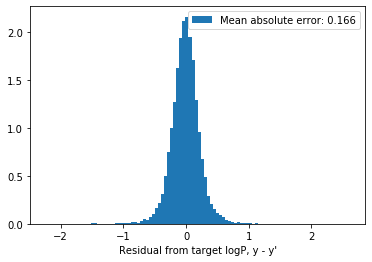

In [18]:
import matplotlib.pyplot as plt
#plt.hist(np.array(all_residual).squeeze(), bins=50, color= 'g', density=True);
plt.hist(lstm_residual, bins=100,density=True)
plt.xlabel('Residual from target logP, y - y\'');
plt.legend(('Mean absolute error: 0.166', 'correlation', 0.87),           
           loc='upper right')
#correlation: 0.87
#correlation: 0.16'

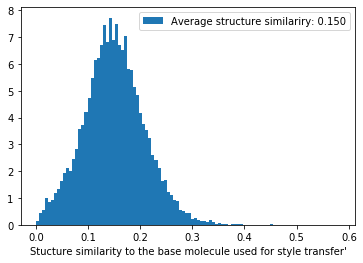

In [23]:
import matplotlib.pyplot as plt
#plt.hist(np.array(all_residual).squeeze(), bins=50, color= 'g', density=True);
plt.hist(lstm_sim, bins=100,density=True)
plt.xlabel('Stucture similarity to the base molecule used for style transfer\'');
plt.legend(('Average structure similariry: 0.150', 'correlation', 0.87),           
           loc='upper right')
#correlation: 0.87
#correlation: 0.16'

In [ ]:
import matplotlib.pyplot as plt
plt.hist(np.array(all_residual).squeeze(), bins=50, color= 'g', density=True);
plt.hist(lstm_residual, bins=50, alpha = 0.5, color= 'b',density=True)
plt.xlabel('Residual from target logP, y - y\'');
plt.legend(('CGD-VAE-3-GRU', 'LSTM', 'correlation', 0.87),           
           loc='upper right')
#correlation: 0.87
#correlation: 0.16'

In [ ]:
import matplotlib.pyplot as plt
plt.hist(np.array(all_sim).squeeze(), bins=50, color= 'g', density=True);
plt.hist(lstm_sim, bins=50, alpha = 0.5, color= 'b',density=True)
plt.xlabel('Stucture similarity to the base molecule used for style transfer\'');
plt.legend(('CGD-VAE-3-GRU', 'LSTM'),
           loc='upper right')


#average Tanimoto similarity: 0.586
#, average Tanimoto similarity: 0.1503

In [ ]:
lstm_residual.shape

In [ ]:
lstm_sim.mean()

In [ ]:
np.array(all_sim).mean()

# UAI rebutal: compare with the cvae resulst, sucess rate:

In [ ]:
numbers = []
import random

for i in range(50):
    n = 1 
    k = random.randrange(0, 5000, 1)
    sigma = 0.0966
    nb_latent_point= 100
    target_y= test_labels[k:k+1, label_index]
    target_labels =  np.tile(target_y, (nb_latent_point, 1))
    target_labels = target_labels.transpose().reshape(nb_latent_point * n )
    latent_point = np.random.normal(0, sigma, size=(target_labels.shape[0], cmd_args.latent_dim))
    z = latent_point.astype(np.float32)
    decoded_string = model.decode(z, target_labels.astype(float), use_random = True)
    obtained_label, index = get_label_from_string(decoded_string)
    obtained_logp = np.array(obtained_label)[:,2]
    true_logp = target_labels[index] * logP_normalizer
    error = (np.absolute(obtained_logp - true_logp) / true_logp)
    numbers.append(error[error<=0.1].shape[0])

In [ ]:
target_y = 1.5
target_y = target_y /logP_normalizer
n = 1
sigma = 0.0966
nb_latent_point= 200
target_labels =  np.tile(target_y, (nb_latent_point, 1))
target_labels = target_labels.transpose().reshape(nb_latent_point * n )
latent_point = np.random.normal(0, sigma, size=(target_labels.shape[0], cmd_args.latent_dim))
z = latent_point.astype(np.float32)
decoded_string = model.decode(z, target_labels.astype(float), use_random = True)
obtained_label, index = get_label_from_string(decoded_string)
obtained_logp = np.array(obtained_label)[:,2]
true_logp = target_labels[index] * logP_normalizer
   

In [ ]:
true_logp

In [ ]:
obtained_logp.shape

In [ ]:
obtained_logp.std()

In [ ]:
error = (np.absolute(obtained_logp - true_logp) / true_logp)

In [ ]:
error[error< 0.15]

In [ ]:
obtained_logp[error< 0.15].std()